In [ ]:
import pandas as pd
import numpy as np
import re

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_news_final_project = pd.read_csv('/content/drive/MyDrive/UChicago/NLP/news_final_project_cleaned.csv')
df_ai = pd.read_csv('/content/drive/MyDrive/UChicago/NLP/news_final_project_ai_filtered.csv')


In [ ]:
df_ai.shape, df_news_final_project.shape

((181932, 4), (192706, 4))

In [ ]:
df = pd.merge(df_ai[['url']] ,df_news_final_project, how='left', on='url')

## Data Preprocessing

In [ ]:
df.head()

,url,date,title_clean,text_clean
0,http://businessnewsthisweek.com/business/infog...,2023-05-20,Infogain AI Business Solutions Now Available i...,Infogain AI Business Solutions Now Available i...
1,https://allafrica.com/stories/202504250184.html,2025-04-25,Africa: AI Policies in Africa - Lessons From G...,Africa: AI Policies in Africa - Lessons From G...
2,https://asiatimes.com/2023/07/yang-lan-intervi...,2023-07-25,Yang Lan interviews academics on AI development,Yang Lan interviews academics on AI developmen...
3,https://cdn.meritalk.com/articles/commerce-nom...,2025-02-04,Commerce Nominee Promises Increased Domestic A...,Commerce Nominee Promises Increased Domestic A...
4,https://citylife.capetown/hmn/uncategorized/re...,2023-11-11,Revolutionizing the Manufacturing Industry: Th...,Revolutionizing the Manufacturing Industry: Th...


In [ ]:
df['text_clean'][1550]

'Billie Eilish among group asking AI developers to honor artist rights – NBC Boston Skip to content Main Navigation Search Search for: Local Weather Investigations Videos Sports U.S. & World Traffic Newsletters Live TV Trending 24/7 streaming news Solar eclipse 2024 Karen Read trial Ana Walshe podcast Tevin Wooten\'s Boston Marathon journey Kwani Has Questions Paris Olympics @Issue NBC Sports Boston Expand Music & Musicians Miranda Lambert, Billie Eilish, Nicki Minaj among signers of letter to AI developers asking to honor artists\' rights The Artist Rights Alliance is an artist-led nonprofit organization that advocates for musicians in a precarious digital economy. By Maria Sherman | Associated Press • Published 44 mins ago • Updated 43 mins ago Getty Images Stevie Wonder, Miranda Lambert, Billie Eilish, Nicki Minaj, Peter Frampton, Katy Perry, Smokey Robinson and J Balvin are just some of the over 200 names featured on a new open letter submitted by the Artist Rights Alliance nonprof

In [ ]:
df['title_clean'][1550]

'Billie Eilish among group asking AI developers to honor artist rights'

In [ ]:
import re

header_keywords = [
    "about us", "contact us", "donate", "email newsletters", "follow us", "home",
    "how to listen", "latest news", "listen online", "login", "log into your account",
    "main navigation", "menu", "meet the team", "more from", "newsletter", "password recovery",
    "pressroom", "privacy policy", "programs", "radio schedule", "recover your password",
    "resources", "search", "shop", "sign in", "sign up", "skip to content", "submit an event",
    "submit guest blogs", "submit press release", "subscribe", "support", "trending",
    "twitter", "facebook", "instagram", "linkedin", "youtube", "join", "username",
    "password", "email", "get help", "share on"
    "network", "welcome" ,"news releases","register"
]

def clean_article_header(text, keywords, max_chars=1500, max_cut_distance=300):

    text = text.strip()
    header_region = text[:max_chars].lower()
    last_cut_position = 0

    while True:
        found = False
        for keyword in keywords:
            idx = header_region.find(keyword)
            if idx != -1 and (idx - last_cut_position) <= max_cut_distance:
                cut_position = idx + len(keyword)
                text = text[cut_position:].strip()
                header_region = text[:max_chars].lower()
                last_cut_position = 0
                found = True
                break
        if not found:
            break

    return text

def clean_text(text):
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text.replace('\xa0', ' ')).strip()

    # Remove headers
    text = clean_article_header(text,header_keywords)

    # Keep only English letters, numbers, basic punctuation
    text = re.sub(r"[^A-Za-z0-9 ,.'\"!?()-]", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join(word for word in text.split() if len(word) <= 25)

    return text

In [ ]:
df['text_clean'] = df['text_clean'].apply(clean_text)

In [ ]:
def clean_title(text):
    text = re.sub(r"[^A-Za-z0-9 ,.'\"!?()-]", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['title_clean'] = df['title_clean'].apply(clean_title)

In [ ]:
df['text_clean'][1550]

'24 7 streaming news Solar eclipse 2024 Karen Read trial Ana Walshe podcast Tevin Wooten\'s Boston Marathon journey Kwani Has Questions Paris Olympics Issue NBC Sports Boston Expand Music Musicians Miranda Lambert, Billie Eilish, Nicki Minaj among signers of letter to AI developers asking to honor artists\' rights The Artist Rights Alliance is an artist-led nonprofit organization that advocates for musicians in a precarious digital economy. By Maria Sherman Associated Press Published 44 mins ago Updated 43 mins ago Getty Images Stevie Wonder, Miranda Lambert, Billie Eilish, Nicki Minaj, Peter Frampton, Katy Perry, Smokey Robinson and J Balvin are just some of the over 200 names featured on a new open letter submitted by the Artist Rights Alliance nonprofit, calling on artificial intelligence tech companies, developers, platforms, digital music services and platforms to stop using AI "to infringe upon and devalue the rights of human artists, according to the letter. The Artist Rights Al

In [ ]:
df.to_csv('/content/drive/MyDrive/UChicago/NLP/news_final_project_cleaned.csv')

In [ ]:
df.shape

(181932, 4)

## Topic modeling

In [ ]:
# !pip install bertopic

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN

In [ ]:
ai_general_keywords = [
    "ai", "artificial intelligence", "machine learning", "deep learning",
    "neural network", "llm", "language model", "chatbot",
     "large model", "data science",  "data", "algorithm",
    "copilot", "transformer", "computer vision"
]

def remove_generic_ai_words(text):
    pattern = r'\b(?:' + '|'.join(map(re.escape, ai_general_keywords)) + r')\b'
    return re.sub(pattern, '', text, flags=re.IGNORECASE).strip()

title = df['title_clean'].tolist()
title_industry_only = [remove_generic_ai_words(t) for t in title]


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import MaximalMarginalRelevance
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

vectorizer = CountVectorizer(stop_words=list(ENGLISH_STOP_WORDS),
                             lowercase=True,
                             token_pattern=r'(?u)\b[A-Za-z][A-Za-z]{2,}\b' )

representation_model = MaximalMarginalRelevance(
    diversity=0.7,
    top_n_words=10  )

In [ ]:
embedding_model = SentenceTransformer("paraphrase-MiniLM-L6-v2", device='cpu' )

hdbscan_model = HDBSCAN(
        min_cluster_size=100,
        min_samples=20,
        cluster_selection_epsilon=0.1,
        cluster_selection_method='eom',
    )


topic_model = BERTopic(
        embedding_model=embedding_model,
        hdbscan_model=hdbscan_model,
        min_topic_size=100,
        vectorizer_model=vectorizer,
        representation_model=representation_model,
        top_n_words=8,
        low_memory=True
    )
topics, probs = topic_model.fit_transform(title_industry_only)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
vocab = topic_model.vectorizer_model.get_feature_names_out()

stop_words_present = [word for word in ["the", "is", "to"]
                     if word in vocab]
print("Stop words in vocab:", stop_words_present)  # Should be []

Stop words in vocab: []


In [ ]:
top10 = topic_model.get_topic_info()
top10

,Topic,Count,Name,Representation,Representative_Docs
0,-1,77704,-1_platform_launches_generative_chatgpt,"[platform, launches, generative, chatgpt, micr...",[ChatGPT take on the future of app development...
1,0,2565,0_chatgpt_prompts_jobs_free,"[chatgpt, prompts, jobs, free, asked, replace,...","[Here s what s new with ChatGPT, And now ChatG..."
2,1,2490,1_nvidia_chip_huang_stocks,"[nvidia, chip, huang, stocks, jensen, demand, ...",[Nvidia Is Not the Only Company Making Chips ...
3,2,2443,2_gmail_maps_workspace_docs,"[gmail, maps, workspace, docs, ads, rivalry, e...",[Google to test ads in generative search resu...
4,3,2015,3_stocks_wall_motley_bubble,"[stocks, wall, motley, bubble, bull, cathie, g...",[Stocks Are Hot Here Are the 3 Best Stocks to ...
...,...,...,...,...,...
301,300,101,300_alphabet_earnings_googl_growth,"[alphabet, earnings, googl, growth, miss, pare...",[Alphabet Goes All In on (). Is It Time to Go...
302,301,101,301_murati_cto_hugging_geospatial,"[murati, cto, hugging, geospatial, field, broa...",[Insider Q A OpenAI CTO Mira Murati on shepher...
303,302,101,302_rishi_ukraine_sunak_limits,"[rishi, ukraine, sunak, limits, hackers, objec...","[Rishi Sunak goes to Washington with Ukraine, ..."
304,303,100,303_elvis_inner_gmail_hologram,"[elvis, inner, gmail, hologram, youtube, perfo...",[Google brings its Bard into its inner circl...


In [ ]:
reduced_topics = topic_model.reduce_outliers(title_industry_only, topics)
topic_model.update_topics(
    title_industry_only,
    topics=reduced_topics,
    vectorizer_model=vectorizer,
    representation_model=representation_model
)

2025-05-15 04:00:14,810 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [ ]:
vocab = topic_model.vectorizer_model.get_feature_names_out()

stop_words_present = [word for word in ["the", "is", "to"]
                     if word in vocab]
print("Stop words in vocab:", stop_words_present)  # Should be []

Stop words in vocab: []


In [ ]:
top10 = topic_model.get_topic_info()
top10

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3,-1_opaleshoni_painkiller_wotsogolera_vitamin,"[opaleshoni, painkiller, wotsogolera, vitamin,...",[ChatGPT take on the future of app development...
1,0,3311,0_chatgpt_prompts_blocking_regrid,"[chatgpt, prompts, blocking, regrid, explainer...","[Here s what s new with ChatGPT, And now ChatG..."
2,1,2857,1_nvidia_chips_trillion_jensen,"[nvidia, chips, trillion, jensen, supercompute...",[Nvidia Is Not the Only Company Making Chips ...
3,2,2694,2_gmail_workspace_duet_maps,"[gmail, workspace, duet, maps, ads, testing, c...",[Google to test ads in generative search resu...
4,3,2314,3_stocks_wall_bubble_bull,"[stocks, wall, bubble, bull, cathie, consider,...",[Stocks Are Hot Here Are the 3 Best Stocks to ...
...,...,...,...,...,...
301,300,167,300_googl_nasdaq_miss_earnings,"[googl, nasdaq, miss, earnings, parent, alphas...",[Alphabet Goes All In on (). Is It Time to Go...
302,301,177,301_cto_shepherding_murati_hugging,"[cto, shepherding, murati, hugging, football, ...",[Insider Q A OpenAI CTO Mira Murati on shepher...
303,302,634,302_rishi_sunak_ukraine_agenda,"[rishi, sunak, ukraine, agenda, limits, mass, ...","[Rishi Sunak goes to Washington with Ukraine, ..."
304,303,217,303_elvis_maps_gmail_hologram,"[elvis, maps, gmail, hologram, hal, return, yo...",[Google brings its Bard into its inner circl...


In [ ]:
top10.head(20)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3,-1_opaleshoni_painkiller_wotsogolera_vitamin,"[opaleshoni, painkiller, wotsogolera, vitamin,...",[ChatGPT take on the future of app development...
1,0,3311,0_chatgpt_prompts_blocking_regrid,"[chatgpt, prompts, blocking, regrid, explainer...","[Here s what s new with ChatGPT, And now ChatG..."
2,1,2857,1_nvidia_chips_trillion_jensen,"[nvidia, chips, trillion, jensen, supercompute...",[Nvidia Is Not the Only Company Making Chips ...
3,2,2694,2_gmail_workspace_duet_maps,"[gmail, workspace, duet, maps, ads, testing, c...",[Google to test ads in generative search resu...
4,3,2314,3_stocks_wall_bubble_bull,"[stocks, wall, bubble, bull, cathie, consider,...",[Stocks Are Hot Here Are the 3 Best Stocks to ...
5,4,2860,4_skills_workforce_americans_fear,"[skills, workforce, americans, fear, replace, ...",[Impact of on Jobs in the UK 10-30 of Jobs Co...
6,5,2356,5_usd_cagr_growth_projected,"[usd, cagr, growth, projected, technavio, shar...",[() Market Size to reach USD 135.8 Billion By ...
7,6,2024,6_altman_openai_days_fired,"[altman, openai, days, fired, candor, founder,...","[With Sam Altman back as CEO, what's next for ..."
8,7,1816,7_ryzen_lenovo_asus_lake,"[ryzen, lenovo, asus, lake, processor, msi, lu...","[AMD, Intel and Nvidia's latest moves in the ..."
9,8,1851,8_iphone_features_siri_cook,"[iphone, features, siri, cook, airpods, rollou...",[Apple's iPhone 16 will put features in focus...


In [ ]:
df['topic'] = reduced_topics

In [ ]:
df.head()

,url,date,title_clean,text_clean,topic
0,http://businessnewsthisweek.com/business/infog...,2023-05-20,Infogain AI Business Solutions Now Available i...,Infogain AI Business Solutions Now Available i...,53
1,https://allafrica.com/stories/202504250184.html,2025-04-25,Africa AI Policies in Africa - Lessons From Gh...,Africa AI Policies in Africa - Lessons From Gh...,93
2,https://asiatimes.com/2023/07/yang-lan-intervi...,2023-07-25,Yang Lan interviews academics on AI development,a link to a friend (Opens in new window)Click ...,261
3,https://cdn.meritalk.com/articles/commerce-nom...,2025-02-04,Commerce Nominee Promises Increased Domestic A...,"Details By Andrew Rice Feb 3, 2025 4 14 pm Com...",52
4,https://citylife.capetown/hmn/uncategorized/re...,2023-11-11,Revolutionizing the Manufacturing Industry The...,Revolutionizing the Manufacturing Industry The...,5


In [ ]:
industries = [
    "AI Development",
    "Technology",
    "Healthcare",
    "Finance & Stock Markets",
    "Marketing & Sales",
    "Automotive",
    "Education",
    "Media & Entertainment",
    "Government & Policy",
    "Cybersecurity",
    "Legal Services",
    "Energy & Environment",
    "Transportation & Logistics",
    "Employment & Workforce",
    "Manufacturing & Industry",
    "Lifestyle & Family",
    "Food & Restaurants",
    "Business & Startups"
]

In [ ]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)

Device set to use cuda:0


In [ ]:
topic_industry_map = {}
for topic_id in range(0, len(top10)-1):
    topic_words = " ".join([word for word, _ in topic_model.get_topic(topic_id)[:5]])
    result = classifier(topic_words, candidate_labels=industries)
    topic_industry_map[topic_id] = result["labels"][0]

In [ ]:
topic_industry_map

{0: 'Technology',
 1: 'Technology',
 2: 'Employment & Workforce',
 3: 'Finance & Stock Markets',
 4: 'Employment & Workforce',
 5: 'Technology',
 6: 'AI Development',
 7: 'Technology',
 8: 'Technology',
 9: 'Education',
 10: 'Technology',
 11: 'Business & Startups',
 12: 'Technology',
 13: 'Employment & Workforce',
 14: 'Finance & Stock Markets',
 15: 'Energy & Environment',
 16: 'Marketing & Sales',
 17: 'Healthcare',
 18: 'Technology',
 19: 'Technology',
 20: 'Government & Policy',
 21: 'Government & Policy',
 22: 'Technology',
 23: 'Technology',
 24: 'Education',
 25: 'Manufacturing & Industry',
 26: 'Technology',
 27: 'Technology',
 28: 'Government & Policy',
 29: 'Cybersecurity',
 30: 'Healthcare',
 31: 'Media & Entertainment',
 32: 'Technology',
 33: 'Legal Services',
 34: 'Automotive',
 35: 'Technology',
 36: 'Technology',
 37: 'Technology',
 38: 'Media & Entertainment',
 39: 'Healthcare',
 40: 'Media & Entertainment',
 41: 'Manufacturing & Industry',
 42: 'Technology',
 43: 'Me

In [ ]:
df['industry'] = df['topic'].map(topic_industry_map)
df['industry'].value_counts()

,count
industry,
Technology,77019
Healthcare,14535
Government & Policy,13843
Employment & Workforce,13820
Media & Entertainment,9219
Finance & Stock Markets,7872
AI Development,6716
Lifestyle & Family,6435
Cybersecurity,6329


In [ ]:
df = df[df['topic']!=-1].copy()

In [ ]:
top10['industry']= top10['Topic'].map(topic_industry_map)

In [ ]:
top10.to_csv('/content/drive/MyDrive/UChicago/NLP/topic_info.csv')
df[['url','topic','industry']].to_csv('/content/drive/MyDrive/UChicago/NLP/news_final_project_topics.csv')

### Investigate Topics' quality

In [ ]:
# set width
pd.set_option('display.max_colwidth', 200)
top10.head(15)

,Topic,Count,Name,Representation,Representative_Docs,industry
0,-1,3,-1_opaleshoni_painkiller_wotsogolera_vitamin,"[opaleshoni, painkiller, wotsogolera, vitamin, itha, yaubongo, jar, kusintha, atero, neurosurgeon]","[ChatGPT take on the future of app development, Microsoft In the public Big tech giants like Microsoft, Meta, Google experiment with tools, Delaware Imaging Network Launches the Enhanced Breast...",NaN
1,0,3311,0_chatgpt_prompts_blocking_regrid,"[chatgpt, prompts, blocking, regrid, explainer, make, jobs, ability, laugh, money]","[Here s what s new with ChatGPT, And now ChatGPT, ChatGPT]",Technology
2,1,2857,1_nvidia_chips_trillion_jensen,"[nvidia, chips, trillion, jensen, supercomputer, wall, rally, rtx, value, reliance]","[Nvidia Is Not the Only Company Making Chips -- Here Are 7 Other Stocks, Best Stock to Buy Nvidia vs. C3., Better () Stock for 2024 Nvidia vs. Microsoft]",Technology
3,2,2694,2_gmail_workspace_duet_maps,"[gmail, workspace, duet, maps, ads, testing, crawlers, gemma, generative, engine]","[Google to test ads in generative search results, Google will work into search results, Google I O 2023 Google Adds Generative to Search]",Employment & Workforce
4,3,2314,3_stocks_wall_bubble_bull,"[stocks, wall, bubble, bull, cathie, consider, dividend, growth, rally, penny]","[Stocks Are Hot Here Are the 3 Best Stocks to Buy, 2 Top () Growth Stocks to Buy Now, 3 () Stocks to Buy in May]",Finance & Stock Markets
5,4,2860,4_skills_workforce_americans_fear,"[skills, workforce, americans, fear, replace, impact, baristas, chefs, imf, hunting]","[Impact of on Jobs in the UK 10-30 of Jobs Could be Automated with, Which jobs are in demand, and the Future of Jobs]",Employment & Workforce
6,5,2356,5_usd_cagr_growth_projected,"[usd, cagr, growth, projected, technavio, share, taiwan, driving, landscape, redefining]","[() Market Size to reach USD 135.8 Billion By 2026 Growing at 14.8 CAGR, () in Security Market Size to Grow USD 13450 Million by 2029 at a CAGR of 18.1, Large () Market Size to Grow USD 40.8 Bill...",Technology
7,6,2024,6_altman_openai_days_fired,"[altman, openai, days, fired, candor, founder, lack, reinstates, chaos, eightfold]","[With Sam Altman back as CEO, what's next for OpenAI, With Sam Altman back as CEO, what's next for OpenAI, With Sam Altman back as CEO, what's next for OpenAI]",AI Development
8,7,1816,7_ryzen_lenovo_asus_lake,"[ryzen, lenovo, asus, lake, processor, msi, lunar, flapmax, photonics, ceva]","[AMD, Intel and Nvidia's latest moves in the PC chip race, AMD launches chips to take on leader Nvidia plans new chip every year - Tech News, Intel, AMD chips-powered PCs won't get Plus featur...",Technology
9,8,1851,8_iphone_features_siri_cook,"[iphone, features, siri, cook, airpods, rollout, race, delay, mac, talks]","[Apple's iPhone 16 will put features in focus, The next iPhone SE could have Apple's features report, What Is Apple s New ?]",Technology


In [ ]:
# I review top 50 topics it mismatch only 12/50 --> 24%
topic_industry_map[2]='Technology'
topic_industry_map[15]='Government & Policy'
topic_industry_map[22]='Finance & Stock Markets'
topic_industry_map[27]='Automotive'
topic_industry_map[28]='Technology'
topic_industry_map[25]= 'AI Development'
topic_industry_map[30]= 'Media & Entertainment'
topic_industry_map[37]= 'Media & Entertainment'
topic_industry_map[38]= 'Legal Services'
topic_industry_map[43]= 'Government & Policy'
topic_industry_map[47]= 'Media & Entertainment'
topic_industry_map[49]= 'Government & Policy'

In [ ]:
topic_industry_map[43]

'Government & Policy'

In [ ]:
top10['industry']= top10['Topic'].map(topic_industry_map)
df['industry'] = df['topic'].map(topic_industry_map)
df['industry'].value_counts()

,count
industry,
Technology,74990
Government & Policy,15390
Employment & Workforce,13820
Healthcare,13334
Media & Entertainment,9643
Finance & Stock Markets,8874
AI Development,7658
Lifestyle & Family,6435
Cybersecurity,6329


In [ ]:
df.loc[df['industry']=='Technology','title_clean'].sample(10)

,title_clean
107790,"Microsoft inks deal with France's Mistral AI, an OpenAI..."
176395,Self-learning AI Chatbots for E-commerce Benefits and Implementation - The European Business Review
71274,Edamam Provides Data for the Creation of an AI Model for Personalized Meal Recommendations
48737,Apica Announces Generative AI Assistant For Ascent Platform
181141,Culture Amp Selects Google Cloud to Drive Generative AI Innovation and Governance
71736,"Customer Feedback Platform unitQ Named Stevie Award Winner for ""Cutting-Edge"" AI Advancements"
89032,InMed AI Receives FDA 510(k) clearance for NeuroShield
175447,"The In-Plant Logistics For Automobile Oems Market Is Projected To Grow By USD 557.8 Million From 2024-2028, Driven By AI And Automated Guided Vehicles..."
55788,OpenAI has reportedly made a potentially scary AI breakthrough
65996,New Chef Dataset Brings AI to Cooking


In [ ]:
df.loc[df['industry']=='Healthcare',['title_clean','topic']].sample(10)

,title_clean,topic
12891,Artificial Intelligence (AI) in Drug Discovery Market Worth 8.95 Billion by 2030 - Exclusive Report by Meticulous Research,85
55478,Exploring The Unexplained Death Of The Steve Jobs Of AI,108
116412,Treatment.com AI and SPRYT Join Forces to Improve Patient Access to Healthcare Services,17
19487,Everyone Deserves a Career Copilot FutureFit AI Launches New AI Career Assistant in Beta,203
165543,ConcertAI's TeraRecon Adds Cardio Suite to its Eureka Clinical AI Platform,254
45764,Botkeeper Lands Google Cloud AI Expert Ben Royce as Keynote for First-Ever AI Unchained Conference,203
11546,Stagwell's (STGW) PRophet Sponsors an Axios Event about the Future of AI and Communications at SXSW 2023,182
59479,Belgian woman blames ChatGPT-like chatbot ELIZA for her husband s suicide,108
97636,New Approach Chinese Scientists Develop Robotic AI Chemist to Extract Oxygen on Mars,291
117625,Dia Imaging taps Intel toolkit to boost cardiac ultrasound AI analysis time,158


In [ ]:
df.loc[df['industry']=='Government & Policy',['title_clean','topic']].sample(10)

,title_clean,topic
5564,White House pushes tech industry to shut down market for sexually abusive AI deepfakes,52
43453,What s Real and What s not Wisconsin Lawmakers Grapple With AI in Elections,64
162085,Can supercomputers give Europe an edge in the AI race?,20
37134,Vatican to host event on Risks and Opportunities of AI for children',94
55328,Britain will host AI summit at World War Two code-breaking centre,49
128551,"G7 Leaders Tackle Migration, Artificial Intelligence On The Second Day Of Their Summit In Italy",20
165978,CVPR Reveals Top Five Trends in Computer Vision,213
139218,Sunak and Biden to discuss AI after extinction risk warning,52
80657,United Digestive Announces Artificial Intelligence System for Enhanced Colonoscopy Screenings,115
106498,"Who is Ilya Sutskever, the man at the center of OpenAI s leadership shakeup and why is he so worried about AI superintelligence going rogue?",241


In [ ]:
df.loc[df['industry']=='Employment & Workforce',['title_clean','topic']].sample(10)

,title_clean,topic
170040,Everlaw Wins Industry Awards for Groundbreaking AI in its Ediscovery Platform,13
178441,"Earnest Analytics releases machine learning revenue forecasting algorithm, Reported Metric Predictions by Earnest AI",176
179616,Now for the hard part Deploying AI at scale,68
17213,"Best AI Search Engines of 2024 Google, Perplexity, and More",2
91451,"Data Scientist Salary in Tucson (Sierra Vista), AZ",13
25725,"With ChatGPT turning 1, Americans wonder whether AI is coming for their jobs",4
128730,Adore Me Taps Duet AI in Google Workspace to Supercharge Collaboration,2
33100,"PwC 2024 Review Revenue Growth, AI Innovation Net Zero",176
12378,Liang Wenfeng The Face of China's AI Renaissance,63
57761,"One in three workers want AI banned from the workplace, while nearly half fear it will threaten their future job security",4


In [ ]:
top10.loc[top10['Topic']==176]

,Topic,Count,Name,Representation,Representative_Docs,industry
177,176,684,176_earnings_earnest_beats_pushes,"[earnings, earnest, beats, pushes, buffett, microsoft, boost, tsmc, unlocked, riyadh]","[Microsoft reports boost in profits, revenue, as it pushes, Microsoft reports boost in profits, revenue, as it pushes, Microsoft reports boost in profits, revenue, as it pushes]",Employment & Workforce


In [ ]:
df.loc[df['topic']==176,'title_clean'].sample(10)

,title_clean
34281,Microsoft quarterly profit rises 20 as tech giant pushes to get customers using AI products
27673,TSMC posts flat Q4 revenue but beats market expectations on AI boom
160197,Phaidra Uses AI to Boost Industrial Profitability and Reduce Emissions
150134,"Earnest Analytics releases machine learning revenue forecasting algorithm, Reported Metric Predictions by Earnest AI"
176381,Foxconn beats estimates with record fourth-quarter revenue on AI demand
59760,Chipmaker Marvell Sees AI Revenue Soaring In The Coming Years
181491,Nvidia to release earnings as AI demand continues unabated
158647,Nvidia beats earnings expectations as investors eye demand for Blackwell AI chips
135013,Property developers could make up to 40 additional profits through AI - News
118253,Microsoft profit rises 20 as tech giant pushes to get customers using AI products


### 2nd Topic modeling using zero shot voting

In [ ]:
df_ai = df.copy()
df_ai.shape

(181929, 6)

In [ ]:
df_ai.drop(columns=['industry'], inplace=True)

In [ ]:
from collections import Counter

topic_industry_map_2 = {}

for topic_id in range(0, len(top10) - 1):
    # Get top 5 keywords
    topic_keywords = " ".join([word for word, _ in topic_model.get_topic(topic_id)[:5]])
    result_keywords = classifier(topic_keywords, candidate_labels=industries)
    keyword_label = result_keywords["labels"][0]

    # Get top 3 representative documents
    rep_docs = topic_model.get_representative_docs(topic_id)[:3]
    doc_labels = []
    for doc in rep_docs:
        result = classifier(doc, candidate_labels=industries)
        doc_labels.append(result["labels"][0])

    # Voting
    all_labels = [keyword_label] + doc_labels
    majority_label = Counter(all_labels).most_common(1)[0][0]

    topic_industry_map_2[topic_id] = majority_label

In [ ]:
topic_industry_map_2

{0: 'Technology',
 1: 'Technology',
 2: 'Technology',
 3: 'Finance & Stock Markets',
 4: 'Employment & Workforce',
 5: 'Employment & Workforce',
 6: 'Technology',
 7: 'Technology',
 8: 'Technology',
 9: 'Education',
 10: 'Business & Startups',
 11: 'Business & Startups',
 12: 'Technology',
 13: 'Employment & Workforce',
 14: 'Technology',
 15: 'Technology',
 16: 'Marketing & Sales',
 17: 'Healthcare',
 18: 'Technology',
 19: 'Technology',
 20: 'Government & Policy',
 21: 'Government & Policy',
 22: 'Technology',
 23: 'Technology',
 24: 'Education',
 25: 'Technology',
 26: 'Lifestyle & Family',
 27: 'Technology',
 28: 'AI Development',
 29: 'Cybersecurity',
 30: 'Technology',
 31: 'Media & Entertainment',
 32: 'Technology',
 33: 'Legal Services',
 34: 'Technology',
 35: 'Technology',
 36: 'Technology',
 37: 'Technology',
 38: 'Technology',
 39: 'Healthcare',
 40: 'Media & Entertainment',
 41: 'Technology',
 42: 'Technology',
 43: 'Government & Policy',
 44: 'Technology',
 45: 'Healthcar

In [ ]:
top10_2 = topic_model.get_topic_info()
top10_2['industry']= top10_2['Topic'].map(topic_industry_map_2)
top10_2['industry1']= top10_2['Topic'].map(topic_industry_map)
df_ai['industry'] = df_ai['topic'].map(topic_industry_map_2)

In [ ]:
df_ai['industry'].value_counts()

,count
industry,
Technology,108307
Employment & Workforce,14453
Government & Policy,13884
Business & Startups,7886
Media & Entertainment,6803
Finance & Stock Markets,6064
Healthcare,5995
Education,5311
Marketing & Sales,2893


In [ ]:
top10_2.head()

,Topic,Count,Name,Representation,Representative_Docs,industry,industry1
0,-1,3,-1_opaleshoni_painkiller_wotsogolera_vitamin,"[opaleshoni, painkiller, wotsogolera, vitamin, itha, yaubongo, jar, kusintha, atero, neurosurgeon]","[ChatGPT take on the future of app development, Microsoft In the public Big tech giants like Microsoft, Meta, Google experiment with tools, Delaware Imaging Network Launches the Enhanced Breast...",NaN,NaN
1,0,3311,0_chatgpt_prompts_blocking_regrid,"[chatgpt, prompts, blocking, regrid, explainer, make, jobs, ability, laugh, money]","[Here s what s new with ChatGPT, And now ChatGPT, ChatGPT]",Technology,Technology
2,1,2857,1_nvidia_chips_trillion_jensen,"[nvidia, chips, trillion, jensen, supercomputer, wall, rally, rtx, value, reliance]","[Nvidia Is Not the Only Company Making Chips -- Here Are 7 Other Stocks, Best Stock to Buy Nvidia vs. C3., Better () Stock for 2024 Nvidia vs. Microsoft]",Technology,Technology
3,2,2694,2_gmail_workspace_duet_maps,"[gmail, workspace, duet, maps, ads, testing, crawlers, gemma, generative, engine]","[Google to test ads in generative search results, Google will work into search results, Google I O 2023 Google Adds Generative to Search]",Technology,Employment & Workforce
4,3,2314,3_stocks_wall_bubble_bull,"[stocks, wall, bubble, bull, cathie, consider, dividend, growth, rally, penny]","[Stocks Are Hot Here Are the 3 Best Stocks to Buy, 2 Top () Growth Stocks to Buy Now, 3 () Stocks to Buy in May]",Finance & Stock Markets,Finance & Stock Markets


In [ ]:
topic_industry_map_2[5]='Finance & Stock Markets'
topic_industry_map_2[15]='Government & Policy'
topic_industry_map_2[22]='Finance & Stock Markets'
topic_industry_map_2[27]='Automotive'
topic_industry_map_2[28]='Technology'
topic_industry_map_2[34]='Automotive'
topic_industry_map_2[37]= 'Media & Entertainment'
topic_industry_map_2[38]= 'Legal Services'
topic_industry_map_2[41]= 'Government & Policy'
topic_industry_map_2[43]= 'Government & Policy'
topic_industry_map_2[46]= 'Finance & Stock Markets'
topic_industry_map_2[47]= 'Media & Entertainment'
topic_industry_map_2[50]= 'Government & Policy'
topic_industry_map_2[56]= 'Finance & Stock Markets'

In [ ]:
df_ai.loc[df_ai['industry']=='Healthcare','title_clean'].sample(10)

,title_clean
175150,UW Artificial Intelligence is headed towards doctors offices and it is not always a good thing KIRO 7 News Seattle
158720,Get a Lifetime of Tailored Piano Instruction From This 150 AI App
170258,Report Half of healthcare professionals embrace AI in clinical practice
32418,Meet your future child with Remini Baby AI Generator
80702,"99 Fanfarons - Bard Sheet music for Trombone, Tuba, Flute, Saxophone alto more instruments (Mixed Ensemble)"
154655,OSF HealthCare Increasing Access to Innovative Patient Care with Artificial Intelligence Diagnostic System
40396,Generative AI In Healthcare And Life Sciences
12169,"Duke Health, Microsoft partner on AI in health care initiative"
113100,News of Harm Humanity in Crisis as Those Targeted Non-Consensually Reporting Being Held Within AI MK Ultra Pain Research Projects are Possibly Being Used in Martyrdom Forms of Brain Heart Soul Har...
109429,MEDSIR and I3LUNG Partners Meet to Advance the Application of AI to Lung Cancer


In [ ]:
df_ai.loc[df_ai['industry']=='Employment & Workforce','title_clean'].sample(10)

,title_clean
143184,Deutsche Telekom Network Monitored By AI Solution from BENOCS and Anodot
127131,Pacific Life Data Scientist Salary - 68K- 95.2K
95877,4 in 10 Workers Believe Generative AI Will Have a Positive Impact on Their Career
57017,TotalEnergies Data Scientist Salary - 65K- 104K
89420,Artist Uses AI to Reimagine Bollywood's Hera Pheri Franchise under Cristopher Nolan's Direction
174029,Strava Data Scientist Salary - 154K- 218K
37166,Maximus to Help DOD Identify AI Data Use Joe Kehoe Quoted
171145,"Hotel Hospitality Management Software Market To Grow By USD 1.64 Billion (2024-2028), Cost Reduction In Hospitality Boosts Market, AI Impact Report ..."
69426,"Email Security Market To Grow By USD 5.17 Billion (2024-2028), Increase In Employee Mobility Boosts The Market, Report On How AI Is Redefining Landsca..."
151343,"Data Scientist Salary in Brampton, Canada"


In [ ]:
df_ai.loc[df_ai['industry']=='Government & Policy',['title_clean','topic']].sample(10)

,title_clean,topic
18819,Donald Trump falsely claims Kamala Harris' campaign used AI to alter photo of crowd size,147
4144,What will the balance between human and AI influence look like in the future of recruitment? - Resourcing - HR Grapevine,250
55375,"Artificial intelligence is gaining state lawmakers attention, and they have a lot of questions",64
120038,Europe s new AI regulation is smothering,20
91271,International students conclude their participation in Global AI Summit to attract global capabilities,49
13753,"Orby Expands Industry s Leading Research, Machine Learning",180
102161,Senior Data Engineer,21
125338,Workday Announces AI Marketplace to Help Customers Easily Discover and Deploy Industry-Leading AI and ML Solutions,180
24,Google to require prominently disclosure of AI use in election ads,256
54882,Company that created ChatGPT is thrown into turmoil after Microsoft hires its ousted CEO - WFRV Local 5,127


In [ ]:
df_ai.loc[df_ai['industry']=='Technology','title_clean'].sample(10)

,title_clean
86056,Denver high school kids built an AI app to help immigrants vote
37014,3 essential abilities AI is missing
46227,"China's Alibaba, Tencent and Baidu join the ChatGPT rush"
32518,Opera browser will use Google's Gemini to power AI features
118155,"Tech companies try to take AI image generators mainstream with better protections against misuse, ET BrandEquity"
37910,Meta Slammed By AI Researchers For Benchmark Manipulation With Maverick AI Model
148491,Schiphol and Pangiam innovate with artificial intelligence in security process
74934,"Micron Shares Slipping 8 After Hours 'Bad News' But 'Good News' Is The AI Trade Is Intact, Says Gene Munster - Micron Technology (NASDAQ MU)"
102531,Italy Privacy Regulator Opens Probe on OpenAI Over ChatGPT
127537,"Physicist Dr. Michio Kaku Says This Technology Will Revolutionize AI Chat-Bots, And Not For The Better"


In [ ]:
df_ai = pd.merge(df_ai , top10_2[['Topic','Representation']].rename(columns={'Topic':'topic'}), how='left', on='topic')

In [ ]:
df_ai.head(1)

,url,date,title_clean,text_clean,topic,industry,Representation
0,http://businessnewsthisweek.com/business/infogain-ai-business-solutions-now-available-in-the-microsoft-azure-marketplace/,2023-05-20,Infogain AI Business Solutions Now Available in the Microsoft Azure Marketplace Business News This Week,"Infogain AI Business Solutions Now Available in the Microsoft Azure Marketplace Business News This Week Business News May 20, 2023 Courtyard by Marriott Mahabaleshwar Announces Three New Leadershi...",53,Business & Startups,"[small, entrepreneurs, unlocking, ango, pyramid, transformation, annotation, gramener, trainual, optimal]"


In [ ]:
key_words = ['native stew']
pattern = '|'.join(map(re.escape, key_words))

df_ai = df_ai[~df_ai['title_clean'].str.contains(pattern, case=False, na=False)]
df_ai.shape

(181339, 7)

In [ ]:
df_ai['industry'] = np.where(df_ai['industry'] == 'AI Development', 'Technology', df_ai['industry'])
df_ai['industry'].value_counts(normalize=True)*100

,proportion
industry,
Technology,60.466309
Employment & Workforce,7.970155
Government & Policy,7.656378
Business & Startups,4.348761
Media & Entertainment,3.426180
Finance & Stock Markets,3.344013
Healthcare,3.305963
Education,2.928769
Marketing & Sales,1.595355


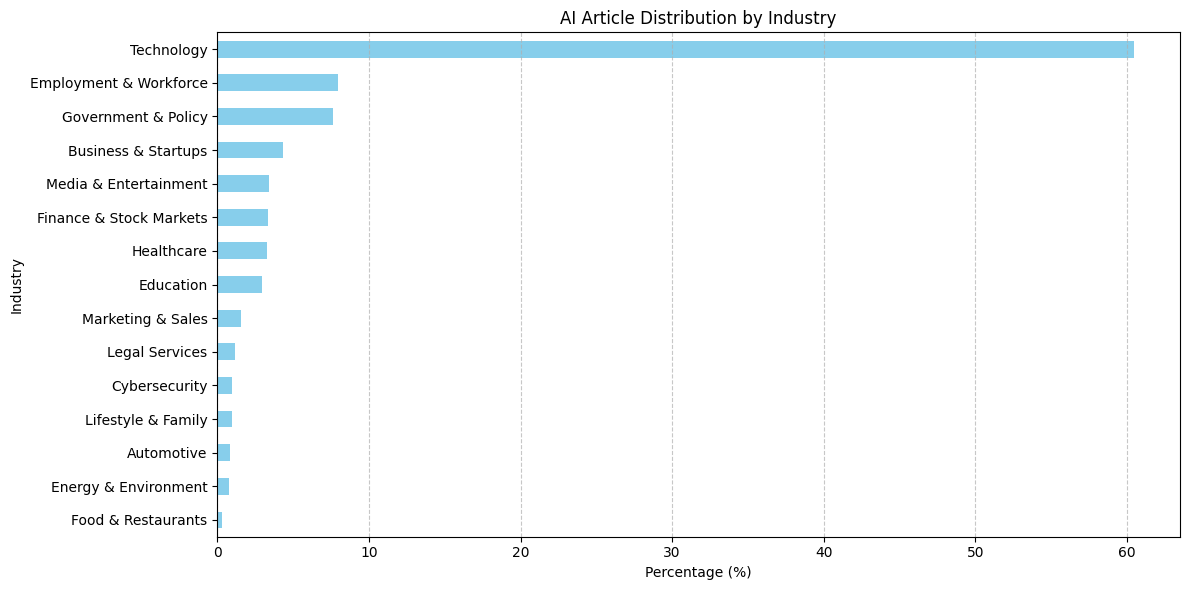

In [ ]:
# Visualization

import matplotlib.pyplot as plt
industry_counts = df_ai['industry'].value_counts(normalize=True) * 100

# Plot
plt.figure(figsize=(12, 6))
industry_counts.plot(kind='barh', color='skyblue')
plt.xlabel("Percentage (%)")
plt.ylabel("Industry")
plt.title("AI Article Distribution by Industry")
plt.gca().invert_yaxis()  # Highest percentage at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
df_ai.to_csv('/content/drive/MyDrive/UChicago/NLP/topic_modeling_completed.csv')

In [ ]:
top10_2.to_csv('/content/drive/MyDrive/UChicago/NLP/topic_info_2.csv')

In [ ]:
df_ai = pd.read_csv('/content/drive/MyDrive/UChicago/NLP/labeled_ai_data_with_entities.csv')

In [ ]:
df_ai.head()

,url,date,title_clean,text_clean,topic,industry,Representation,sentiment,sentiment_score,orgs,people,products,locations
0,http://businessnewsthisweek.com/business/infog...,2023-05-20,Infogain AI Business Solutions Now Available i...,Infogain AI Business Solutions Now Available i...,53,Business & Startups,"['small', 'entrepreneurs', 'unlocking', 'ango'...",positive,0.968321,"['Infogain', 'Microsoft', 'Courtyard by Marrio...","['Dibyendu Bhattacharya', 'Sonu Sood s', 'Anub...","['Azure', 'Azure', 'Azure', 'Azure', 'Azure', ...","['Los Gatos', 'California']"
1,https://allafrica.com/stories/202504250184.html,2025-04-25,Africa AI Policies in Africa - Lessons From Gh...,Africa AI Policies in Africa - Lessons From Gh...,93,Employment & Workforce,"['biontech', 'intellitek', 'founded', 'streaml...",positive,0.953480,['AllAfrica'],"['My Account', 'My Account', 'Thompson Gyedu K...",[],"['Ghana', 'Rwanda', 'Ghana', 'Rwanda', 'Johann..."
2,https://asiatimes.com/2023/07/yang-lan-intervi...,2023-07-25,Yang Lan interviews academics on AI development,a link to a friend (Opens in new window)Click ...,261,Technology,"['office', 'ordered', 'holiday', 'highlighted'...",positive,0.863181,"['Asia Times', 'ISIS', 'the Institute for AI I...","['Yuval Noah Harari', 'Yang Lan', 'Hun Manet',...",['ChatGPT'],"['US', 'China', 'China']"
3,https://cdn.meritalk.com/articles/commerce-nom...,2025-02-04,Commerce Nominee Promises Increased Domestic A...,"Details By Andrew Rice Feb 3, 2025 4 14 pm Com...",52,Government & Policy,"['biden', 'order', 'executive', 'safeguards', ...",positive,0.887693,"['Commerce', 'the Department of Commerce', 'th...","['Andrew Rice', 'Howard Lutnick', 'Donald Trum...",[],"['America', 'America', 'America']"
4,https://citylife.capetown/hmn/uncategorized/re...,2023-11-11,Revolutionizing the Manufacturing Industry The...,Revolutionizing the Manufacturing Industry The...,5,Employment & Workforce,"['usd', 'cagr', 'growth', 'projected', 'techna...",positive,0.960287,[],"['Hla', 'tauj Xov']",[],['Lub neej']


In [ ]:
top10_2 = pd.read_csv('/content/drive/MyDrive/UChicago/NLP/topic_info_2.csv')

In [ ]:
top10_2.drop(columns=['Unnamed: 0'], inplace=True)
top10_2.head()

,Topic,Count,Name,Representation,Representative_Docs,industry,industry1
0,-1,3,-1_opaleshoni_painkiller_wotsogolera_vitamin,"['opaleshoni', 'painkiller', 'wotsogolera', 'v...",['ChatGPT take on the future of app developmen...,NaN,NaN
1,0,3311,0_chatgpt_prompts_blocking_regrid,"['chatgpt', 'prompts', 'blocking', 'regrid', '...","['Here s what s new with ChatGPT', 'And now Ch...",Technology,Technology
2,1,2857,1_nvidia_chips_trillion_jensen,"['nvidia', 'chips', 'trillion', 'jensen', 'sup...",['Nvidia Is Not the Only Company Making Chips...,Technology,Technology
3,2,2694,2_gmail_workspace_duet_maps,"['gmail', 'workspace', 'duet', 'maps', 'ads', ...",['Google to test ads in generative search res...,Technology,Employment & Workforce
4,3,2314,3_stocks_wall_bubble_bull,"['stocks', 'wall', 'bubble', 'bull', 'cathie',...",['Stocks Are Hot Here Are the 3 Best Stocks to...,Finance & Stock Markets,Finance & Stock Markets


,Topic,Count,Name,Representation,Representative_Docs,industry,industry1
16,15,1751,15_journalists_regulating_iso_pressure,"['journalists', 'regulating', 'iso', 'pressure...",['UK Regulation Government Report Highlights ...,Technology,Government & Policy


In [ ]:
# Define the mapping
topic_industry_map_2 = {
    5: 'Finance & Stock Markets',
    15: 'Government & Policy',
    22: 'Finance & Stock Markets',
    27: 'Automotive',
    28: 'Technology',
    34: 'Automotive',
    37: 'Media & Entertainment',
    38: 'Legal Services',
    41: 'Government & Policy',
    43: 'Government & Policy',
    46: 'Finance & Stock Markets',
    47: 'Media & Entertainment',
    50: 'Government & Policy',
    56: 'Finance & Stock Markets'
}

# Update the 'industry' column in the DataFrame
top10_2['industry'] = top10_2['Topic'].map(topic_industry_map_2).fillna(top10_2['industry'])

In [ ]:
top10_2.head(10)

,Topic,Count,Name,Representation,Representative_Docs,industry,industry1
0,-1,3,-1_opaleshoni_painkiller_wotsogolera_vitamin,"['opaleshoni', 'painkiller', 'wotsogolera', 'v...",['ChatGPT take on the future of app developmen...,NaN,NaN
1,0,3311,0_chatgpt_prompts_blocking_regrid,"['chatgpt', 'prompts', 'blocking', 'regrid', '...","['Here s what s new with ChatGPT', 'And now Ch...",Technology,Technology
2,1,2857,1_nvidia_chips_trillion_jensen,"['nvidia', 'chips', 'trillion', 'jensen', 'sup...",['Nvidia Is Not the Only Company Making Chips...,Technology,Technology
3,2,2694,2_gmail_workspace_duet_maps,"['gmail', 'workspace', 'duet', 'maps', 'ads', ...",['Google to test ads in generative search res...,Technology,Employment & Workforce
4,3,2314,3_stocks_wall_bubble_bull,"['stocks', 'wall', 'bubble', 'bull', 'cathie',...",['Stocks Are Hot Here Are the 3 Best Stocks to...,Finance & Stock Markets,Finance & Stock Markets
5,4,2860,4_skills_workforce_americans_fear,"['skills', 'workforce', 'americans', 'fear', '...",['Impact of on Jobs in the UK 10-30 of Jobs C...,Employment & Workforce,Employment & Workforce
6,5,2356,5_usd_cagr_growth_projected,"['usd', 'cagr', 'growth', 'projected', 'techna...",['() Market Size to reach USD 135.8 Billion By...,Finance & Stock Markets,Technology
7,6,2024,6_altman_openai_days_fired,"['altman', 'openai', 'days', 'fired', 'candor'...","[""With Sam Altman back as CEO, what's next for...",Technology,AI Development
8,7,1816,7_ryzen_lenovo_asus_lake,"['ryzen', 'lenovo', 'asus', 'lake', 'processor...","[""AMD, Intel and Nvidia's latest moves in the ...",Technology,Technology
9,8,1851,8_iphone_features_siri_cook,"['iphone', 'features', 'siri', 'cook', 'airpod...","[""Apple's iPhone 16 will put features in focu...",Technology,Technology


In [ ]:
df_ai['industry'] = df_ai['topic'].map(topic_industry_map_2).fillna(df_ai['industry'])

In [ ]:
df_ai.loc[df_ai['topic']==1,['title_clean','industry']].sample(10)

,title_clean,industry
123247,Hashtag Trending Mar.26th- Intel co-founder wh...,Technology
61807,Huawei's AI Ambitions to Rival Nvidia Face Sig...,Technology
169983,Nvidia boss unveils AI products ahead of Taiwa...,Technology
63027,NVIDIA Brings Generative AI to,Technology
176467,Nvidia shares fall after it says US controls o...,Technology
91134,R D Market Pulse NVIDIA hits 37.5B in revenue ...,Technology
18254,"Nvidia Is Still Hot, but These 2 Artificial In...",Technology
172211,Stock Market Selloff Deepens Why Nvidia s AI S...,Technology
110893,Nvidia's stock market value is up 1 trillion i...,Technology
126532,Yotta Data Services Collaborates with NVIDIA t...,Technology


In [ ]:
df_ai.head()

,url,date,title_clean,text_clean,topic,industry,Representation,sentiment,sentiment_score,orgs,people,products,locations
0,http://businessnewsthisweek.com/business/infog...,2023-05-20,Infogain AI Business Solutions Now Available i...,Infogain AI Business Solutions Now Available i...,53,Business & Startups,"['small', 'entrepreneurs', 'unlocking', 'ango'...",positive,0.968321,"['Infogain', 'Microsoft', 'Courtyard by Marrio...","['Dibyendu Bhattacharya', 'Sonu Sood s', 'Anub...","['Azure', 'Azure', 'Azure', 'Azure', 'Azure', ...","['Los Gatos', 'California']"
1,https://allafrica.com/stories/202504250184.html,2025-04-25,Africa AI Policies in Africa - Lessons From Gh...,Africa AI Policies in Africa - Lessons From Gh...,93,Employment & Workforce,"['biontech', 'intellitek', 'founded', 'streaml...",positive,0.953480,['AllAfrica'],"['My Account', 'My Account', 'Thompson Gyedu K...",[],"['Ghana', 'Rwanda', 'Ghana', 'Rwanda', 'Johann..."
2,https://asiatimes.com/2023/07/yang-lan-intervi...,2023-07-25,Yang Lan interviews academics on AI development,a link to a friend (Opens in new window)Click ...,261,Technology,"['office', 'ordered', 'holiday', 'highlighted'...",positive,0.863181,"['Asia Times', 'ISIS', 'the Institute for AI I...","['Yuval Noah Harari', 'Yang Lan', 'Hun Manet',...",['ChatGPT'],"['US', 'China', 'China']"
3,https://cdn.meritalk.com/articles/commerce-nom...,2025-02-04,Commerce Nominee Promises Increased Domestic A...,"Details By Andrew Rice Feb 3, 2025 4 14 pm Com...",52,Government & Policy,"['biden', 'order', 'executive', 'safeguards', ...",positive,0.887693,"['Commerce', 'the Department of Commerce', 'th...","['Andrew Rice', 'Howard Lutnick', 'Donald Trum...",[],"['America', 'America', 'America']"
4,https://citylife.capetown/hmn/uncategorized/re...,2023-11-11,Revolutionizing the Manufacturing Industry The...,Revolutionizing the Manufacturing Industry The...,5,Finance & Stock Markets,"['usd', 'cagr', 'growth', 'projected', 'techna...",positive,0.960287,[],"['Hla', 'tauj Xov']",[],['Lub neej']


In [ ]:
df_ai.to_csv('/content/drive/MyDrive/UChicago/NLP/labeled_ai_data_with_entities_lastest.csv')

In [ ]:
top10_2.to_csv('/content/drive/MyDrive/UChicago/NLP/topic_info_lastest.csv')

In [ ]:
df_ai.shape

(181299, 13)

In [ ]:
df_ai['industry'].value_counts(normalize=True)*100

,proportion
industry,
Technology,54.198865
Government & Policy,9.633258
Employment & Workforce,6.669645
Finance & Stock Markets,6.130756
Media & Entertainment,4.486511
Business & Startups,4.349721
Healthcare,3.306692
Education,2.929415
Automotive,2.003320


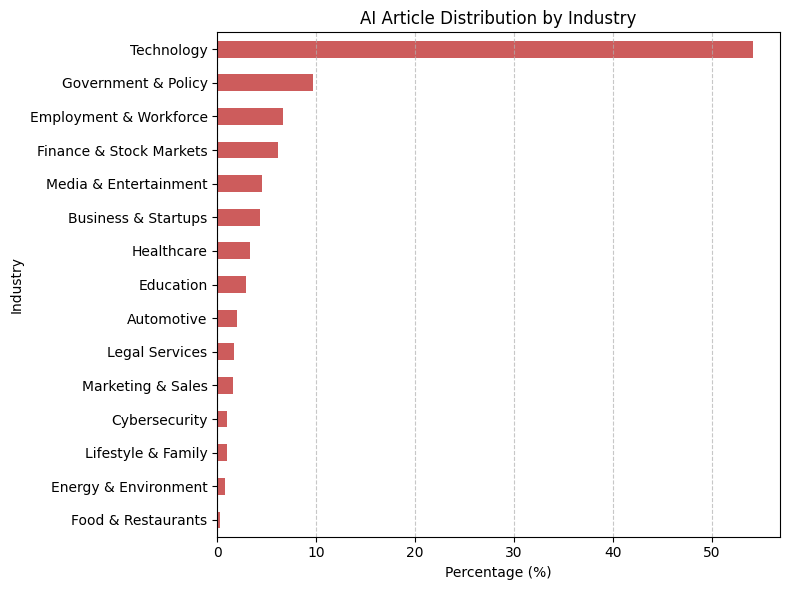

In [ ]:
import matplotlib.pyplot as plt
industry_counts = df_ai['industry'].value_counts(normalize=True) * 100

# Plot
plt.figure(figsize=(8, 6))
industry_counts.plot(kind='barh', color='indianred')
plt.xlabel("Percentage (%)")
plt.ylabel("Industry")
plt.title("AI Article Distribution by Industry")
plt.gca().invert_yaxis()  # Highest percentage at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
df_ai = pd.read_csv('/content/drive/MyDrive/UChicago/NLP/labeled_ai_data_with_entities_lastest.csv')

In [ ]:
df_ai.drop(columns=['Unnamed: 0'], inplace=True)
df_ai.head()

,url,date,title_clean,text_clean,topic,industry,Representation,sentiment,sentiment_score,orgs,people,products,locations
0,http://businessnewsthisweek.com/business/infog...,2023-05-20,Infogain AI Business Solutions Now Available i...,Infogain AI Business Solutions Now Available i...,53,Business & Startups,"['small', 'entrepreneurs', 'unlocking', 'ango'...",positive,0.968321,"['Infogain', 'Microsoft', 'Courtyard by Marrio...","['Dibyendu Bhattacharya', 'Sonu Sood s', 'Anub...","['Azure', 'Azure', 'Azure', 'Azure', 'Azure', ...","['Los Gatos', 'California']"
1,https://allafrica.com/stories/202504250184.html,2025-04-25,Africa AI Policies in Africa - Lessons From Gh...,Africa AI Policies in Africa - Lessons From Gh...,93,Employment & Workforce,"['biontech', 'intellitek', 'founded', 'streaml...",positive,0.953480,['AllAfrica'],"['My Account', 'My Account', 'Thompson Gyedu K...",[],"['Ghana', 'Rwanda', 'Ghana', 'Rwanda', 'Johann..."
2,https://asiatimes.com/2023/07/yang-lan-intervi...,2023-07-25,Yang Lan interviews academics on AI development,a link to a friend (Opens in new window)Click ...,261,Technology,"['office', 'ordered', 'holiday', 'highlighted'...",positive,0.863181,"['Asia Times', 'ISIS', 'the Institute for AI I...","['Yuval Noah Harari', 'Yang Lan', 'Hun Manet',...",['ChatGPT'],"['US', 'China', 'China']"
3,https://cdn.meritalk.com/articles/commerce-nom...,2025-02-04,Commerce Nominee Promises Increased Domestic A...,"Details By Andrew Rice Feb 3, 2025 4 14 pm Com...",52,Government & Policy,"['biden', 'order', 'executive', 'safeguards', ...",positive,0.887693,"['Commerce', 'the Department of Commerce', 'th...","['Andrew Rice', 'Howard Lutnick', 'Donald Trum...",[],"['America', 'America', 'America']"
4,https://citylife.capetown/hmn/uncategorized/re...,2023-11-11,Revolutionizing the Manufacturing Industry The...,Revolutionizing the Manufacturing Industry The...,5,Finance & Stock Markets,"['usd', 'cagr', 'growth', 'projected', 'techna...",positive,0.960287,[],"['Hla', 'tauj Xov']",[],['Lub neej']


In [ ]:
top10_2 = pd.read_csv('/content/drive/MyDrive/UChicago/NLP/topic_info_lastest.csv')

In [ ]:
top10_2.drop(columns=['Unnamed: 0'], inplace=True)
top10_2.head()

,Topic,Count,Name,Representation,Representative_Docs,industry,industry1
0,-1,3,-1_opaleshoni_painkiller_wotsogolera_vitamin,"['opaleshoni', 'painkiller', 'wotsogolera', 'v...",['ChatGPT take on the future of app developmen...,NaN,NaN
1,0,3311,0_chatgpt_prompts_blocking_regrid,"['chatgpt', 'prompts', 'blocking', 'regrid', '...","['Here s what s new with ChatGPT', 'And now Ch...",Technology,Technology
2,1,2857,1_nvidia_chips_trillion_jensen,"['nvidia', 'chips', 'trillion', 'jensen', 'sup...",['Nvidia Is Not the Only Company Making Chips...,Technology,Technology
3,2,2694,2_gmail_workspace_duet_maps,"['gmail', 'workspace', 'duet', 'maps', 'ads', ...",['Google to test ads in generative search res...,Technology,Employment & Workforce
4,3,2314,3_stocks_wall_bubble_bull,"['stocks', 'wall', 'bubble', 'bull', 'cathie',...",['Stocks Are Hot Here Are the 3 Best Stocks to...,Finance & Stock Markets,Finance & Stock Markets


In [ ]:
top_ind = df_ai.groupby('industry').size().reset_index(name='count')
top_ind.sort_values(by ='count',ascending=False,inplace=True)
top_ind = top_ind.head(5)


In [ ]:
top_ind

,industry,count
14,Technology,98262
8,Government & Policy,17465
4,Employment & Workforce,12092
6,Finance & Stock Markets,11115
13,Media & Entertainment,8134


In [ ]:
df_ai_top_ind = df_ai[df_ai['industry'].isin(top_ind['industry'])]

<Figure size 1200x600 with 0 Axes>

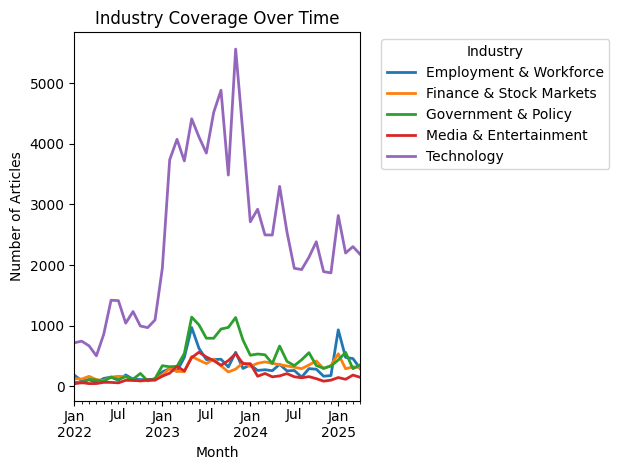

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to monthly period
# df_ai_top_ind['date'] = pd.to_datetime(df_ai_top_ind['date'])
# df_ai_top_ind['month'] = df_ai_top_ind['date'].dt.to_period('M')

# Group by industry and month
industry_time = df_ai_top_ind.groupby(['month', 'industry']).size().unstack(fill_value=0)

# Plot Line Chart
plt.figure(figsize=(12, 6))
industry_time.plot(kind='line', linewidth=2)
plt.title("Industry Coverage Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Articles")
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# For Area Chart, just change plot kind:
# industry_time.plot(kind='area', stacked=True, figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

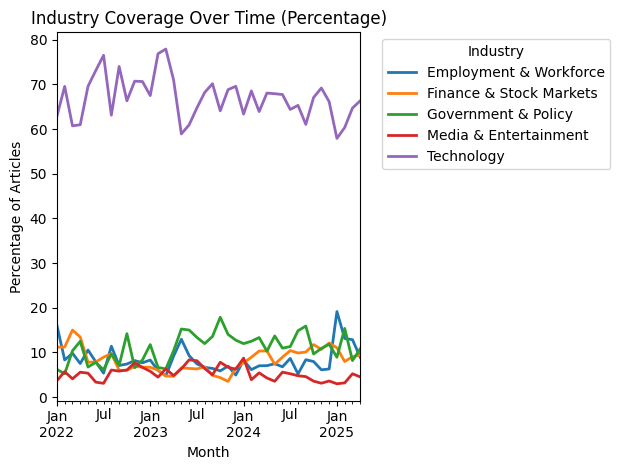

In [ ]:
# Group by month and industry
industry_time = df_ai_top_ind.groupby(['month', 'industry']).size().unstack(fill_value=0)

# Convert article counts to percentages per month
industry_time_pct = industry_time.div(industry_time.sum(axis=1), axis=0) * 100

# Plot Line Chart (percentage)
plt.figure(figsize=(12, 6))
industry_time_pct.plot(kind='line', linewidth=2)
plt.title("Industry Coverage Over Time (Percentage)")
plt.xlabel("Month")
plt.ylabel("Percentage of Articles")
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example input
industry_keywords = {
    'Technology': {'AI': 120, 'cloud': 85, 'automation': 65},
    'Healthcare': {'genomics': 40, 'robotics': 30, 'diagnosis': 25}
}

# Convert to DataFrame
df_keywords = pd.DataFrame(industry_keywords).fillna(0).T  # Transpose for plotting

# Plot
df_keywords.plot(kind='bar', figsize=(10, 6))
plt.title("Top Keywords per Industry")
plt.xlabel("Industry")
plt.ylabel("Keyword Importance")
plt.legend(title="Keywords", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-8-a6cb95acb675>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')


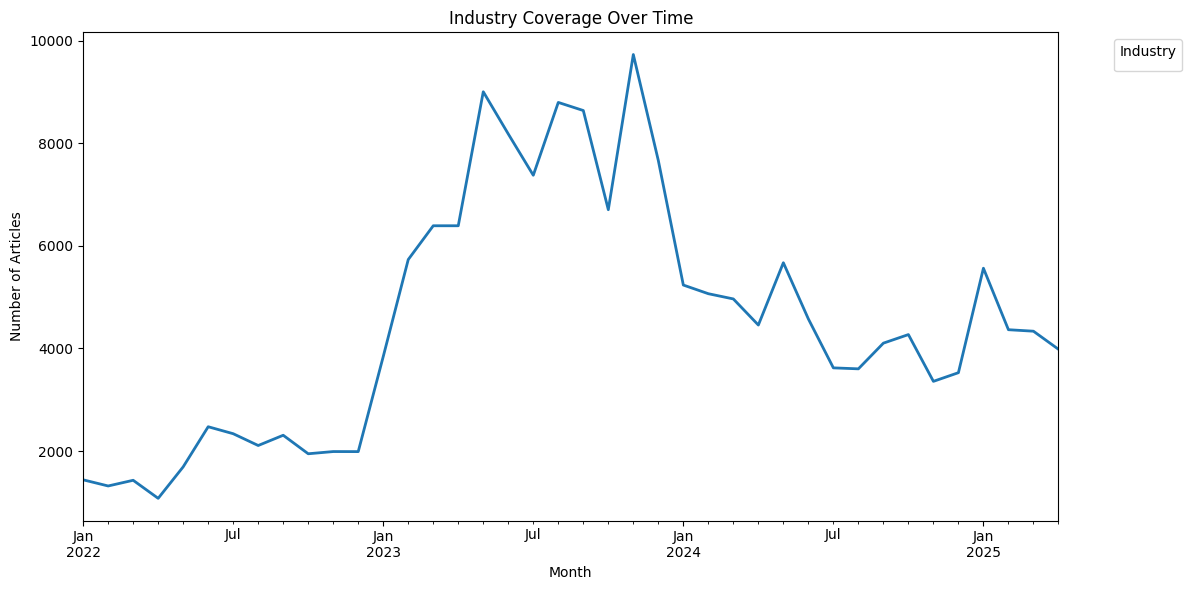

In [ ]:
industry_time = df_ai.groupby('month').size()

# Plot Line Chart
plt.figure(figsize=(12, 6))
industry_time.plot(kind='line', linewidth=2)
plt.title("Industry Coverage Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Articles")
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
from wordcloud import WordCloud
import ast
from matplotlib import pyplot as plt

In [ ]:
def make_word_cloud(top10_2,industry):
    tech_topics = top10_2[top10_2['industry'] == industry]
    keywords = sum(tech_topics['Representation'].apply(ast.literal_eval), [])
    keyword_text = ' '.join(keywords)
    # Generate word cloud
    wordcloud = WordCloud(width=1200, height=400, background_color='white').generate(keyword_text)

    # Plot
    plt.figure(figsize=(14, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud: "+industry+ " Industry Topics")
    plt.tight_layout()
    plt.show()

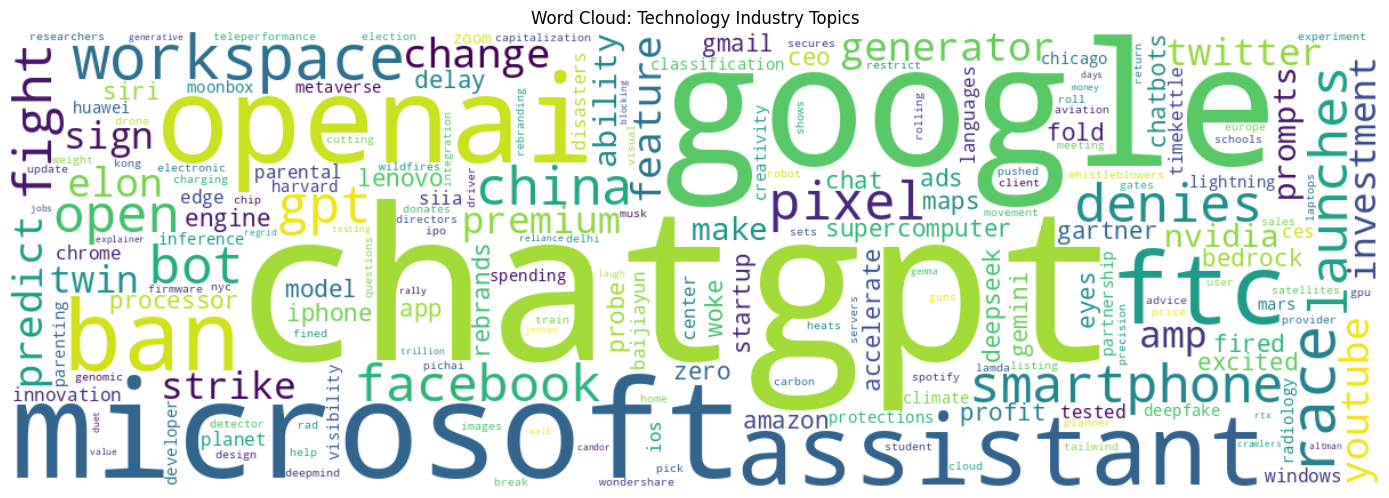

In [ ]:
make_word_cloud(top10_2,'Technology')

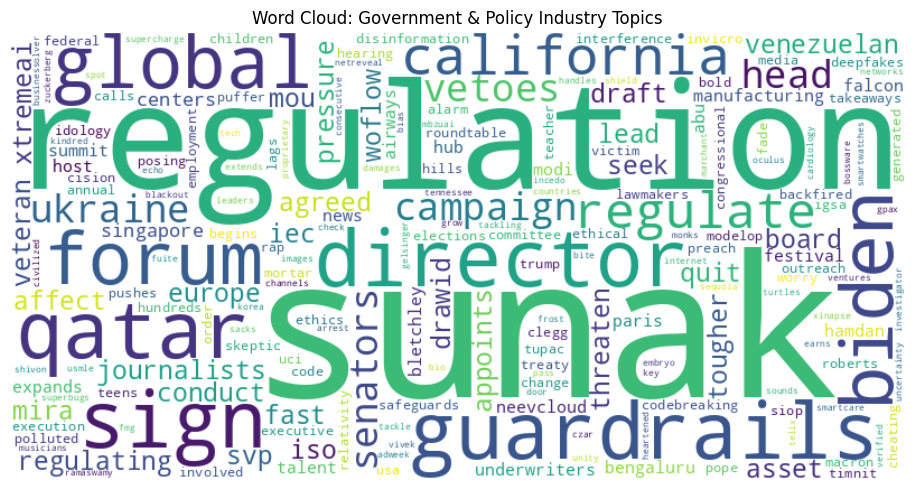

In [ ]:
make_word_cloud(top10_2,'Government & Policy')

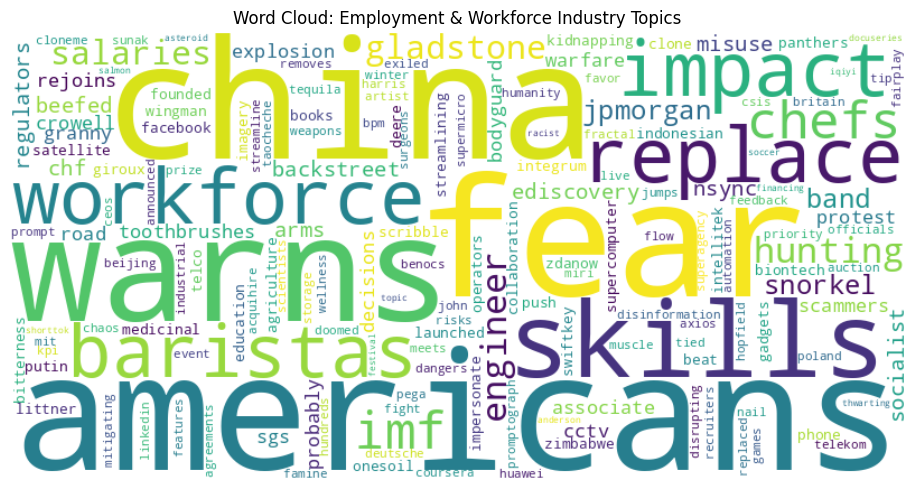

In [ ]:
make_word_cloud(top10_2,'Employment & Workforce')

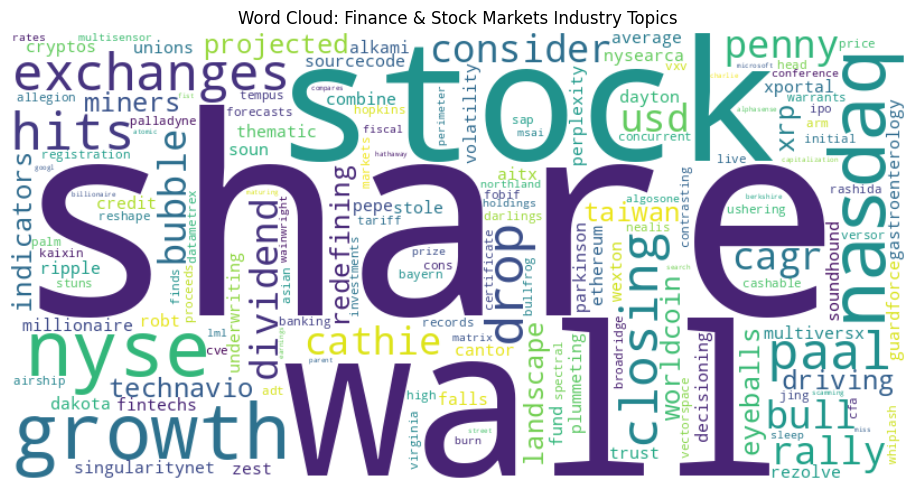

In [ ]:
make_word_cloud(top10_2,'Finance & Stock Markets')